In [94]:
# All imports
import urllib.request as ul
from bs4 import BeautifulSoup
import requests
import re
import datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
#---

senatorwiki = 'http://web.archive.org/web/20200924015849/https://en.wikipedia.org/wiki/List_of_current_United_States_senators'
html = requests.get(senatorwiki)
soup = BeautifulSoup(html.text)
senatortable = soup.find('table',{'class':"sortable"})
rows = senatortable.findAll('tr')

state, name, party, age, occupation, prev, assoff, termup, res = [], [], [], [], [], [], [], [], []

for tr in rows:
    cells=tr.findAll('td')
    alt = tr.findAll('th')
    if len(cells)==9:
        #state.append(cells[0].find(text=True))
        party.append(cells[2].find(text=True))
        occupation.append(cells[4].find(text=True))
        prev.append(cells[5].find(text=True))
        assoff.append(cells[6].find(text=True))
        termup.append(cells[7].find(text=True))
        res.append(cells[8].find(text=True))
        age.append(int(cells[3].find('span','noprint ForceAgeToShow').string[6:-1]))
    if len(cells)==10:
        state.append(cells[0].find(text=True))
        party.append(cells[3].find(text=True))
        occupation.append(cells[5].find(text=True))
        prev.append(cells[6].find(text=True))
        assoff.append(cells[7].find(text=True))
        termup.append(cells[8].find(text=True))
        res.append(cells[9].find(text=True))
        age.append(int(cells[4].find('span','noprint ForceAgeToShow').string[6:-1]))
    if len(alt)==1:
        name.append(alt[0].find(text=True))

stac = [el.find(text=True) for el in rows[0].findAll('th')]
cats = [el.rstrip() for el in stac]
cats.remove('Image')
cats[3] = 'Age'
zcat = dict(zip([str(x) for x in range(len(cats))],cats))

assoff = [x.rstrip() for x in assoff]
assoff = [datetime.datetime.strptime(x,'%B %d, %Y') for x in assoff]
occupation = [x.rstrip() for x in occupation]
termup = [x.rstrip() for x in termup]
termup = [datetime.datetime.strptime(x,'%Y') for x in termup]
states = [x for x in state for i in range(2)]
prev = [x.rstrip() for x in prev]

senators = pd.DataFrame([states,name,party,age,occupation,prev,assoff,termup,res],index=cats).T

today = datetime.date.today()
yrs = pd.Series([senators['Assumed office'][x].year for x in range(len(senators))])

senators['Years served'] = today.year - yrs

#takes the url tails for each senator
url = 'https://justfacts.votesmart.org/candidate/public-statements'
search = 'https://votesmart.org/search?q='
asen ='https://votesmart.org/officials/NA/C/-congressional?chamber=U'
html = requests.get(asen)
soup = BeautifulSoup(html.text)
f = soup.find('h5').find('a')['href'][10:]
soup.findAll('h5')
sencodedict = {line.text:line.find('a')['href'][10:] for line in soup.findAll('h5')}

#updates names to match votesmart
seniority = pd.Series([1 if x%2 else 0 for x in range(1,101)])
senators['Seniority'] = seniority
names = senators['Senator']
surnames = [name.split(' ')[-1] if name.split(' ')[-1] != 'Jr.' else name.split(' ')[-2] for name in names]
senators['Surname'] = surnames
senators = senators.sort_values(by='Surname')

# Alphabetized from votesmart.
sendict = list(sencodedict.keys())
rep = list(sencodedict.keys())
for x in range(len(rep)):
    rep[x] = rep[x].split(' ')
rep = sorted(rep,key=lambda x: x[-1] if (x[-1] != 'Jr.') and (x[-1] != 'III') else x[-2])
for x in range(len(rep)):
    rep[x] = ' '.join(rep[x])
    
senators['Senator'] = rep

alphalist = list(senators['Senator'])
femwiki = 'https://en.wikipedia.org/wiki/Women_in_the_United_States_Senate'
femhtml = requests.get(femwiki)
chickensoup = BeautifulSoup(femhtml.text)
femtable = chickensoup.find('table',{'class':"sortable"})
frows = femtable.findAll('tr')
ttxt = []
for line in femtable.findAll('a'):
    ttxt.append(line.text)
femlist = [x for x in alphalist if x.split(' ')[-1] in [x.split(' ')[-1] for x in ttxt]]
gender = [1 if x not in femlist else 0 for x in alphalist]
senators['Gender'] = gender

party = {}
party[senators['Party'].unique()[0]] = 1
party[senators['Party'].unique()[1]] = -1
party[senators['Party'].unique()[2]] = 0
party_list = [party[x] for x in senators['Party']]
senators['Partynum'] = party_list

# analysis groups
posgrp = ['noun','verb','adj','adv','intj','pron','wh','conj','prep']
lengthgrp = ['short word', 'long word', 'short sent', 'long sent']
humorgrp = ['glb humor', 'glb humor M', 'glb humor F', 'glb humor young', 'glb humor old']
emot_all = ['joy', 'fear', 'sadness', 'anticipation', 'anger', 'disgust', 'trust', 'surprise']
emot_glb = ['glb '+x for x in emot_all]
emot_loc = ['loc '+x for x in emot_all]
ratios = ['short/long','words/sent','verb/noun','noun/pron']
dif_uni = ['% diff w/func','% unique w/func', '% frag']

# SOME THOUGHTS -- I wonder if it would be worthwhile to (later, of course) also do a regional analysis.

# senators data
allsens = pd.read_csv('allsens_2020.csv')

IDs = {}
for x in range(len(allsens.person.unique())):
    IDs[allsens.person.unique()[x]] = x    
allsens['ID'] = allsens['person'].map(IDs)

females = allsens[allsens['gender']==0]
males = allsens[allsens['gender']==1]

meanage = allsens['age'].mean()
old = allsens[allsens['age']>meanage]
young = allsens[allsens['age']<=meanage]

partydic = {'Republican':1,'Democratic':-1,'Independent':0}
allsens['parnum'] = allsens['party'].map(partydic)
# partydic = pd.Series(senators.Partynum.values,index=senators.Senator).to_dict()
# partydic = pd.Series(senators.Partynum.values,index=senators.Senator).to_dict()
# allsens['party'] = [partydic[x] for x in allsens['person']]
republicans = allsens[allsens['parnum']==1]
democrats = allsens[allsens['parnum']==-1]
independents = allsens[allsens['parnum']==0]
dems_and_ind = allsens[allsens['parnum']<1]

# basic features - means
allsens_means = dict(allsens.mean())
females_means = dict(females.mean())
males_means = dict(males.mean())
old_means = dict(old.mean())
young_means = dict(young.mean())
repub_means = dict(republicans.mean())
demo_means = dict(democrats.mean())

# stds
allsens_stds = dict(allsens.std())
females_stds = dict(females.std())
males_stds = dict(males.std())
old_stds = dict(old.std())
young_stds = dict(young.std())
repub_stds = dict(republicans.std())
demo_stds = dict(democrats.std())

# Averaging each senator
sensavg = allsens.groupby('person').mean()

### Not really necessary 
# sensstd = []
# for i in range(100):
#     if not np.isnan(allsens[allsens['person']==sendict[i]].mean()[0]):
#         sensstd.append(allsens[allsens['person']==sendict[i]].std())
# sensstd = pd.DataFrame(sensstd)
# sensstd['gender'] = ['Male' if x==1 else 'Female' for x in sensstd['gender']]
# sensstd['party'] = ['Republican' if x==1 else 'Democrat' if x==-1 else 'Independent' for x in sensstd['parnum']]
# sensstd['ID'] = sensstd['ID'].astype('int')
# sensstd = sensstd.set_index('ID')

# Odd mistake found. This fixes it
testt = []
for ind, row in sensavg.iterrows():
    if row['noun/pron'] == np.inf:
        testt.append(row['noun']/row['pron'])
    else:
        testt.append(row['noun/pron'])
sensavg['noun/pron'] = testt

In [95]:
sensavg

,age,gender,sents,wordcount,noun,verb,adj,adv,intj,pron,...,words/sent,conj/sent,verb/noun,noun/pron,% diff w/func,% unique w/func,misc words,% frag,ID,parnum
person,,,,,,,,,,,,,,,,,,,,,
Amy Klobuchar,60.0,0.0,53.783784,1093.756757,27.306416,18.005873,5.874839,4.244366,0.065270,8.299080,...,21.778156,0.245434,0.686330,3.629615,47.586166,33.432819,1008.767230,9.082317,23.0,1.0
"Angus King, Jr.",76.0,1.0,43.769231,781.692308,24.820086,18.552120,5.610772,4.523239,0.029644,8.537281,...,17.917575,0.385174,0.784115,3.338277,51.588468,36.950197,698.778626,13.968875,74.0,1.0
Ben Cardin,76.0,1.0,62.900000,1219.066667,26.474817,18.232023,7.215464,4.164967,0.049569,7.333591,...,20.406978,0.096418,0.731169,3.995647,41.434995,27.910869,1134.659791,4.942359,7.0,-1.0
Ben Sasse,48.0,1.0,56.565217,1211.043478,25.278022,17.284477,6.936600,4.784500,0.021854,7.478428,...,21.342546,0.174540,0.710902,3.584090,43.406905,28.698494,1127.407378,8.917182,90.0,1.0
Bernie Sanders,78.0,1.0,47.000000,1055.340909,28.953353,15.758420,6.278107,4.470865,0.017712,6.608740,...,21.094454,0.276142,0.580986,6.183396,50.594126,36.738209,971.982604,15.262781,89.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tina Smith,62.0,0.0,71.900000,1528.000000,28.909909,16.982137,7.921597,4.096497,0.020330,7.006722,...,21.850488,0.090799,0.599179,4.530192,39.226778,25.564601,1441.781254,4.034418,93.0,-1.0
Todd Young,48.0,1.0,44.500000,1158.944444,30.492091,16.144002,7.344517,3.890570,0.008032,6.790505,...,33.682572,0.133559,0.545372,12.031947,46.388696,32.237422,1074.192088,10.914804,48.0,1.0
Tom Carper,73.0,1.0,68.333333,1357.277778,28.526238,16.481801,5.691551,4.643186,0.018540,8.638892,...,20.084634,0.164829,0.614162,5.964022,47.032250,33.372704,1272.951932,11.439180,8.0,-1.0


In [5]:
### THOUGHTS 14.9.20
# I need to look at pos ratios, length ratios, fragments, selfishness, and emotion/humor scores, everything else is a wash

# For basic results, I need a way to graph a scatterplot and draw a mean line. For example, plot all Rep. wordcounts, but draw an allsens mean line

# It also wouldn't be a bad idea to resave pkl files for the dataset after the newest cleanups, to save time.

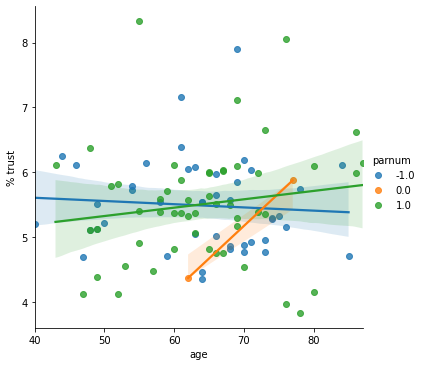

In [97]:
### ROUND THE MAX/MIN AGES TO NEAREST DECADE
sensavg['wordcount_z'] = zscore(sensavg['wordcount'])

sensavg['wordcount_z_bin'] = pd.cut(sensavg['wordcount_z'], np.arange(-2,4,step=1))
sensavg['age_bin'] = pd.cut(sensavg['age'], np.arange(40,90,step=10))
g = sns.lmplot(
    data=sensavg,
    x='age',
    y='% trust',
    hue='parnum')

In [101]:
freshmen = senators[senators['Years served']==0]
longterm = senators[senators['Term up'].dt.year==2026]
midterm = senators[senators['Term up'].dt.year==2024]
shortterm = senators[senators['Term up'].dt.year==2022]
shortterm[shortterm['Party']=='Democratic']

,State,Senator,Party,Age,Occupation(s),Previous,Assumed office,Term up,Residence,Years served,Seniority,Surname,Gender,Partynum
10,Colorado,Marsha Blackburn,Democratic,55,Lawyer,Denver Public Schools,2009-01-22,2022-01-01,Denver,12,1,Bennet,0,-1
12,Connecticut,Roy Blunt,Democratic,74,Marine Corps Reserve,Connecticut Attorney General,2011-01-03,2022-01-01,Greenwich,10,1,Blumenthal,1,-1
25,Illinois,Dick Durbin,Democratic,52,Army National Guard,U.S. House,2017-01-03,2022-01-01,Hoffman Estates,4,0,Duckworth,1,-1
9,California,Martin Heinrich,Democratic,55,Lawyer,Attorney General of California,2017-01-03,2022-01-01,Los Angeles,4,0,Harris,1,-1
57,New Hampshire,John Hickenlooper,Democratic,62,Lawyer,Governor of New Hampshire,2017-01-03,2022-01-01,Newfields,4,0,Hassan,1,-1
39,Maryland,Jim Inhofe,Democratic,61,U.S. Senate staff member,U.S. House,2017-01-03,2022-01-01,Kensington,4,0,Hollen,1,-1
88,Vermont,"Ben Lujan, Jr.",Democratic,80,Lawyer,State's Attorney,1975-01-03,2022-01-01,Middlesex,46,1,Leahy,1,-1
54,Nevada,Catherine Cortez Masto,Democratic,56,Lawyer,Nevada Attorney General,2017-01-03,2022-01-01,Las Vegas,4,1,Masto,0,-1
92,Washington,Jon Ossoff,Democratic,69,Teacher,Washington Senate,1993-01-03,2022-01-01,Seattle,28,1,Murray,1,-1
20,Hawaii,Chuck Schumer,Democratic,47,Teacher,Lieutenant Governor of Hawaii,2012-12-26,2022-01-01,Honolulu,9,1,Schatz,1,-1


In [188]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(sensavg, test_size=0.25, random_state=54321)
exc = ['parnum','% unique no func','% joy', '% surprise', '% anticipation',
       '% anger', '% fear', '% trust', '% disgust', '% sadness','glb anticipation', 'loc anger', 'glb anger',
       'loc sadness', 'glb sadness', 'loc valence', 'glb valence',
       'loc arousal', 'glb arousal', 'loc dominance', 'glb dominance',
       'loc humor', 'glb humor', 'loc humor M', 'glb humor M', 'loc humor F',
       'glb humor F', 'loc humor young', 'glb humor young', 'loc humor old',
       'glb humor old','% diff w/func','wordcount_z', 'wordcount_z_bin', 'age_bin', 'age_bin2',
       '% unique w/func', 'misc words','sents','wordcount','noun','verb','pron','conj','short sent', 'long sent']
ckr = ['age','gender','% joy','% surprise','% anticipation','% anger','% fear','% trust','% sadness','words/sent']

features_train = df_train[ckr]
target_train = df_train['parnum']
features_valid = df_valid[ckr]
target_valid = df_valid['parnum']

best_score = 0
best_depth = 0
for depth in range(1, 10000):
    model = DecisionTreeClassifier(random_state=54321, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    score = accuracy_score(target_valid, predictions_valid)
    if score > best_score:
        best_score = score
        best_depth = depth
        
print("Accuracy of the best model on the validation set (max_depth = {}): {}".format(best_depth, best_score))

final_model = DecisionTreeClassifier(random_state=54321, max_depth=best_depth)
final_model.fit(features_train, target_train)

Accuracy of the best model on the validation set (max_depth = 7): 0.72


DecisionTreeClassifier(max_depth=7, random_state=54321)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

best_score = 0
best_est = 0
for est in range(1, 10000):
    model = RandomForestClassifier(random_state=54321, n_estimators=est)
    model.fit(features_train, target_train)
    score = model.score(features_valid, target_valid)
    if score > best_score:
        best_score = score
        best_est = est

print("Accuracy of the best model on the validation set (n_estimators = {}): {}".format(best_est, best_score))

final_model = RandomForestClassifier(random_state=54321, n_estimators=best_est)
final_model.fit(features_train, target_train)

In [152]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [177]:
maybe = ['age', 'gender', 'sents', 'wordcount', 'noun', 'verb', 'adj', 'adv',
       'intj', 'pron', 'wh', 'conj', 'prep', 'short sent', 'long sent',
       'short word', 'long word', 'frag', '# diff', '% func words', 'selfish',
       '# unique', '% unique no func', '% joy', '% surprise', '% anticipation',
       '% anger', '% fear', '% trust', '% disgust', '% sadness', 'loc fear',
       'glb fear', 'loc joy', 'glb joy', 'loc trust', 'glb trust',
       'loc surprise', 'glb surprise', 'loc disgust', 'glb disgust',
       'loc anticipation', 'glb anticipation', 'loc anger', 'glb anger',
       'loc sadness', 'glb sadness', 'loc valence', 'glb valence',
       'loc arousal', 'glb arousal', 'loc dominance', 'glb dominance',
       'loc humor', 'glb humor', 'loc humor M', 'glb humor M', 'loc humor F',
       'glb humor F', 'loc humor young', 'glb humor young', 'loc humor old',
       'glb humor old', '% humor', '% VAD', 'words/sent',
       'conj/sent', 'verb/noun', 'noun/pron', '% diff w/func',
       '% unique w/func', 'misc words', '% frag']

In [186]:
reasonable = sensavg[maybe]

# printing column name where infinity is present 
print() 
print("printing column name where infinity is present") 
col_name = reasonable.columns.to_series()[np.isinf(reasonable).any()] 
print(col_name) 
  
# printing row index with infinity 
print() 
print("printing row index with infinity ") 
  
r = reasonable.index[np.isinf(reasonable).any(1)] 
print(r) 


printing column name where infinity is present
Series([], dtype: object)

printing row index with infinity 
Index([], dtype='object', name='person')
